### Pair Correlation for ICM Organoids

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.spatial.distance import cdist
from Functions import *

C = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

def graphdistance(tri, Dist, cutoff):
    Gr = nx.Graph()
    
    simplices = tri.simplices[(Dist[tri.simplices[:,0],tri.simplices[:,1]] < cutoff) & 
                              (Dist[tri.simplices[:,0],tri.simplices[:,2]] < cutoff) &
                              (Dist[tri.simplices[:,0],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,1],tri.simplices[:,2]] < cutoff) & 
                              (Dist[tri.simplices[:,1],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,2],tri.simplices[:,3]] < cutoff)]
    
    
    for path in simplices:
        nx.add_path(Gr, path)
        
    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    dist = np.empty([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            dist[i,j] = dist_dict[i][j]
            
    
    return dist
    

def paircorrelation(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    x[(Population == Type)] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


def correlation_correction(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    y = np.zeros(len(Population))
    x[(Population == Type)] = 1
    y[(Population == 'N+G+') | (Population == 'N-G-')] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    cor_ind = np.where(y==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        equals = GraphDist[ind].T[ind].T
        mixed = GraphDist[cor_ind].T[ind].T
        none =  GraphDist[cor_ind].T[cor_ind].T
        
        rho_equals = sum(x)*(sum(x)-1)/len(x)/(len(x)-1)
        rho_mixed = sum(x)*sum(y)/len(x)/(len(x)-1)
        rho_none = sum(y)*(sum(y)-1)/len(x)/(len(x)-1)
        
        rho_total = (sum(x) + sum(y)/2)*(sum(x)-1 + sum(y)/2)/len(x)/(len(x)-1)

        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = (len(equals[equals==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + len(mixed[mixed==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + 0.25*len(none[none==i])/len(GraphDist[GraphDist==i])/rho_total)

    return P


N = []
G = []
N_cor = []
G_cor = []
DN = []
DP = []
nofCells = []
Stage = []
N_mean = 0
G_mean = 0
DN_mean = 0
DP_mean = 0
number = 0
for K in range(max(C['OrganoidID'])):
    Organoids = max(C['OrganoidID'])
    ID = K+1
    Cindex = []
    Cells = []

    for i in range(len(C)):
        if C['OrganoidID'][i] == ID:
            Cindex.append(i)

    x = np.array(C.loc[Cindex,'CentroidX'])
    y = np.array(C.loc[Cindex,'CentroidY'])
    z = np.array(C.loc[Cindex,'CentroidZ'])
    Nanog = np.array(C.loc[Cindex,'Nanog-Avg'])
    Gata6 = np.array(C.loc[Cindex,'Gata6-Avg'])
    Population = np.array(C.loc[Cindex,'Population'])
    stage = np.array(C.loc[Cindex,'stage'])
    
    nofN = len(Population[Population == 'N+G-'])
    nofG = len(Population[Population == 'N-G+'])
    nofDP = len(Population[Population == 'N+G+'])
    nofDN = len(Population[Population == 'N-G-'])
    
    #if nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG < 2 or nofG/nofN < 2:
    if stage[0]=='24h':
    #if nofG == 0:
    #    nofG = 1e-8
    #if nofN == 0:
    #    nofN = 1e-8
        
    #if not (nofDN/len(x) + nofDP/len(x) > 0.25 and stage[0]=='48h' and nofN/nofG < 2 and nofG/nofN < 2):
    #if stage[0]=='48h' or nofDN/len(x) + nofDP/len(x) > 0.25:
    #if (nofDN/len(x) + nofDP/len(x) > 0.30 or nofDN/len(x) + nofDP/len(x) < 0.20 or stage[0]=='24h' or
    #    nofN/len(x) < 0.248 or nofN/len(x) > 0.448 or
    #    nofG/len(x) < 0.307 or nofG/len(x) > 0.507):
        continue

    #N_mean += nofN/len(x)
    #G_mean += nofG/len(x)
    #DN_mean += nofDN/len(x)
    #DP_mean += nofDP/len(x)
    #number += 1
        
    print('Organoid', ID, 'consists of', len(Cindex), 'cells')

    pos = np.empty([len(x), 3])
    pos[:,0] = x
    pos[:,1] = y
    pos[:,2] = z

    Dist = cdist(pos, pos)
    tri = Delaunay(pos)
    GraphDist = graphdistance(tri, Dist, 91)
    
    #Population[Nanog > Gata6] = 'N+G-'
    #Population[Nanog <= Gata6] = 'N-G+'
    N.append(paircorrelation(Population, 'N+G-', GraphDist))
    G.append(paircorrelation(Population, 'N-G+', GraphDist))
    N_cor.append(correlation_correction(Population, 'N+G-', GraphDist))
    G_cor.append(correlation_correction(Population, 'N-G+', GraphDist))
    DN.append(paircorrelation(Population, 'N-G-', GraphDist))
    DP.append(paircorrelation(Population, 'N+G+',GraphDist))
    Stage.append(stage[0])
    nofCells.append(len(x))
    
print('Finished!')

Organoid 7 consists of 1751 cells
Organoid 14 consists of 1531 cells
Organoid 15 consists of 1474 cells
Organoid 16 consists of 1019 cells
Organoid 17 consists of 1479 cells
Organoid 18 consists of 1592 cells
Organoid 19 consists of 1433 cells
Organoid 20 consists of 1410 cells
Organoid 21 consists of 1330 cells
Organoid 22 consists of 1651 cells
Organoid 23 consists of 1032 cells
Organoid 29 consists of 863 cells
Organoid 30 consists of 1425 cells
Organoid 31 consists of 693 cells
Organoid 32 consists of 1133 cells
Organoid 33 consists of 862 cells
Organoid 34 consists of 1334 cells
Organoid 35 consists of 642 cells
Organoid 36 consists of 871 cells
Organoid 37 consists of 707 cells
Organoid 38 consists of 553 cells
Organoid 39 consists of 935 cells
Organoid 40 consists of 1001 cells
Organoid 41 consists of 793 cells
Organoid 42 consists of 675 cells
Organoid 43 consists of 787 cells
Organoid 47 consists of 962 cells
Organoid 48 consists of 1093 cells
Organoid 49 consists of 977 cells

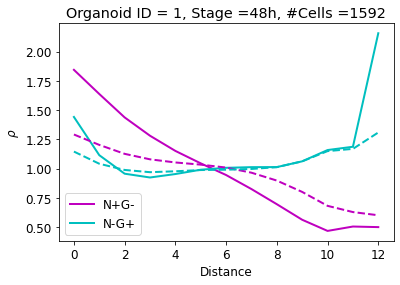

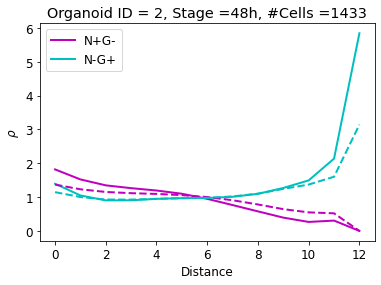

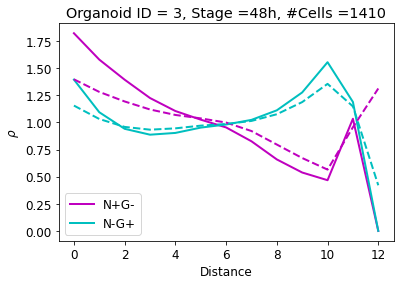

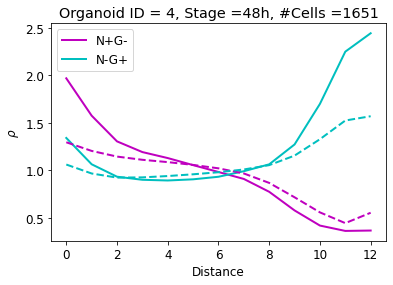

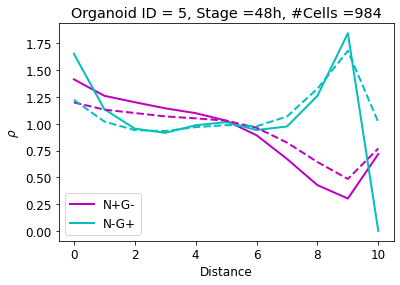

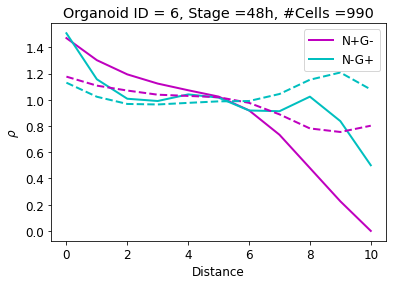

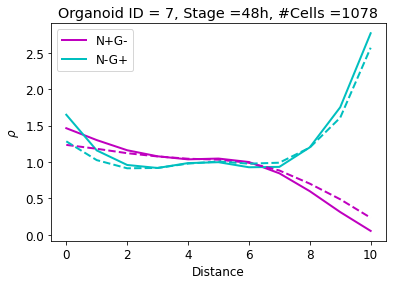

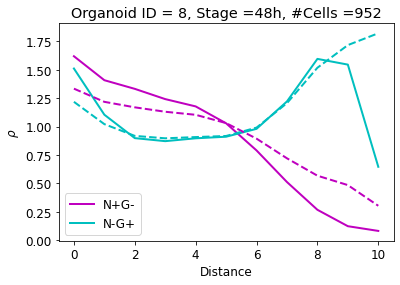

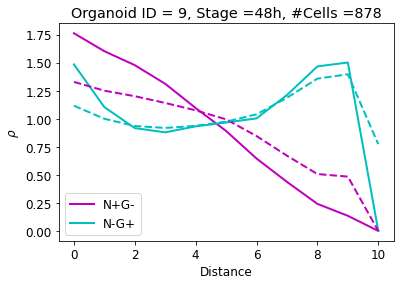

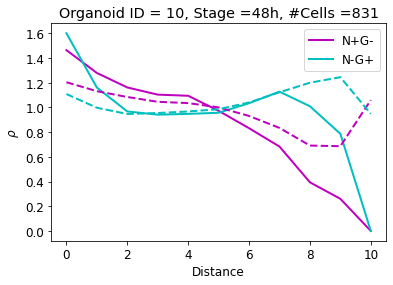

In [82]:
for i in range(len(N)):
    plt.figure()
    plt.rc('font', size=12)
    plt.plot(N[i], 'm', lw=2, label = 'N+G-')
    plt.plot(G[i], 'c', lw=2, label = 'N-G+')
    plt.plot(N_cor[i], 'm--', lw=2)
    plt.plot(G_cor[i], 'c--', lw=2)
    #plt.plot(DP[i], 'k--', alpha = 0.5, lw=2, label = 'N+G+')
    #plt.plot(DN[i], 'k', ls='dotted', alpha = 0.5, lw=2, label = 'N-G-')
    plt.title('Organoid ID = '+str(i+1)+ ', Stage ='+str(Stage[i])+', #Cells ='+str(nofCells[i]))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho$')
    plt.legend()
    #plt.savefig('Results/Pair Correlations (without DN DP)/ID='+str(i+1)+'.png')

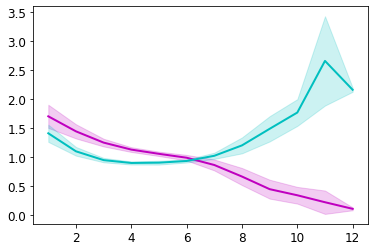

In [3]:
maxdist = 0
for i in range(len(N)):
    if maxdist < len(N[i]):
        maxdist = len(N[i])

amount = np.zeros(maxdist)
N_mean = np.zeros(maxdist)
G_mean = np.zeros(maxdist)
N_std = np.zeros(maxdist)
G_std = np.zeros(maxdist)
DN_mean = np.zeros(maxdist)
DP_mean = np.zeros(maxdist)
DN_std = np.zeros(maxdist)
DP_std = np.zeros(maxdist)
x = list(range(1,maxdist+1))
for i in range(len(N)):
    for j in range(len(N[i])):
        N_mean[j] += N[i][j]
        G_mean[j] += G[i][j]
        DN_mean[j] += DN[i][j]
        DP_mean[j] += DP[i][j]
        amount[j] += 1
        
N_mean = N_mean/amount
G_mean = G_mean/amount


for i in range(len(N)):
    for j in range(len(N[i])):
        N_std[j] += (N[i][j]-N_mean[j])**2
        G_std[j] += (G[i][j]-G_mean[j])**2
        DN_std[j] += (DN[i][j]-DN_mean[j])**2
        DP_std[j] += (DP[i][j]-DP_mean[j])**2
        amount[j] += 1

N_std = (N_std/amount)**(1/2)
G_std = (G_std/amount)**(1/2)
DN_std = (DN_std/amount)**(1/2)
DP_std = (DP_std/amount)**(1/2)
        
plt.plot(x, N_mean, 'm', lw = 2)
plt.plot(x, G_mean, 'c', lw = 2)
#plt.plot(x, DN_mean, 'k', lw = 2)
#plt.plot(x, DP_mean, 'b', lw = 2)
plt.fill_between(x, N_mean - N_std, N_mean + N_std, color='m', alpha = 0.2)
plt.fill_between(x, G_mean - G_std, G_mean + G_std, color='c', alpha = 0.2)
#plt.fill_between(x, DN_mean - DN_std, DN_mean + DN_std, color='k', alpha = 0.2)
#plt.fill_between(x, DP_mean - DP_std, DP_mean + DP_std, color='b', alpha = 0.2)

<br>
<br>
<br>

### Pair correlation for non-local model data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import loadData, fate
import networkx as nx

N = np.empty([9,177])
G = np.empty([9,177])

Pos, Radius, N[0,:], G[0,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=1_10/Data.csv')
Pos, Radius, N[1,:], G[1,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=2_10/Data.csv')
Pos, Radius, N[2,:], G[2,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=3_10/Data.csv')
Pos, Radius, N[3,:], G[3,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=4_10/Data.csv')
Pos, Radius, N[4,:], G[4,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=5_10/Data.csv')
Pos, Radius, N[5,:], G[5,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=6_10/Data.csv')
Pos, Radius, N[6,:], G[6,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=7_10/Data.csv')
Pos, Radius, N[7,:], G[7,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=8_10/Data.csv')
Pos, Radius, N[8,:], G[8,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=9_10/Data.csv')

FVmesh = initializeFVmesh(Pos, Radius=Radius)
Gr = nx.Graph()
for path in FVmesh.Tri.simplices:

    path1 = [path[0], path[1]]
    path2 = [path[1], path[2]]
    path3 = [path[2], path[0]]

    if FVmesh.Dist[path1[0],path1[1]] < 2.2:
        nx.add_path(Gr, path1)
    if FVmesh.Dist[path2[0],path2[1]] < 2.2:    
        nx.add_path(Gr, path2)
    if FVmesh.Dist[path3[0],path3[1]] < 2.2:
        nx.add_path(Gr, path3)
    
dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
GraphDist = np.empty([FVmesh.nofCells, FVmesh.nofCells])
for i in range(FVmesh.nofCells):
    for j in range(FVmesh.nofCells):
        GraphDist[i,j] = dist_dict[i][j]

colors = np.linspace(0,1,9)       
cmap = matplotlib.cm.get_cmap('jet')
plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(N[i,:], G[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')

test = np.linspace(0,1,len(PN)-2)
plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.png')

plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(G[i,:], N[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.png')

<br>
<br>
<br>

### Pair correlation / cell ratio for local model data

Text(0, 0.5, 'Proportion')

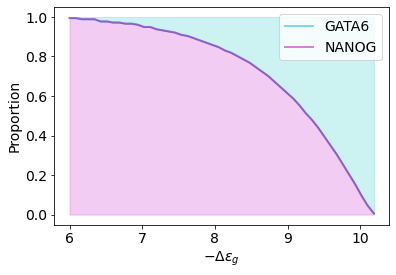

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import networkx as nx
import pandas as pd
import os

def paircorrelation(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


Prm = setParameters()
#Organoid = initializeOrganoid(Prm)
Pos = np.array(pd.read_csv('testOrganoid.csv'))
Radius = np.ones(len(Pos))*1.1
FVmesh = initializeFVmesh(Pos, Radius=Radius)


x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
xInit = np.array([gauss(x0[0],x0[0]*0.01) if i < FVmesh.nofCells else 
                  gauss(x0[1],x0[1]*0.01) for i in range(2*FVmesh.nofCells)])

#eps_G = np.linspace(6,7.86,20)
q = 0.9
Prm.range = q
s_max = np.max((1-q)/q*np.sum(Prm.r_G/Prm.gamma_G*q**FVmesh.GraphDist, axis=0))
upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)
eps_G = np.linspace(-Prm.eps_N, upper_boundary, 50)
Ratio = np.empty(eps_G.shape)
PN = np.empty([len(eps_G), int(np.max(FVmesh.GraphDist))])
PG = np.empty([len(eps_G), int(np.max(FVmesh.GraphDist))])

for i in range(len(eps_G)):
    Prm.eps_G = -eps_G[i]
    Prm.T = 2400
    Prm.nofSteps = 3000
    t = np.linspace(0,Prm.T,Prm.nofSteps)
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]

    F = fate(N, G)
    #PN[i,:] = paircorrelation(N, G, FVmesh.GraphDist)
    #PG[i,:] = paircorrelation(G, N, FVmesh.GraphDist)

    Ratio[i] = np.sum(F)/FVmesh.nofCells



plt.rc('font', size=14)
plt.plot(eps_G, Ratio, 'c', alpha=0.5, lw=2, label = 'GATA6')
plt.plot(eps_G, Ratio, 'm', alpha=0.5, lw=2, label = 'NANOG')
plt.fill_between(eps_G, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_G, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportion')

Text(0, 0.5, 'Proportion')

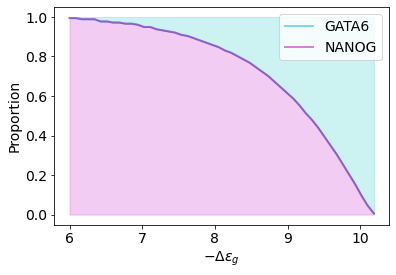

In [19]:
plt.figure()
plt.rc('font', size=14)
plt.plot(eps_G, Ratio, 'c', alpha=0.5, lw=2, label = 'GATA6')
plt.plot(eps_G, Ratio, 'm', alpha=0.5, lw=2, label = 'NANOG')
plt.fill_between(eps_G, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_G, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportion')
#plt.savefig('Results/Publications/Pattern Formation/Proportions q=0_9.pdf')
#plt.savefig('Results/Publications/Pattern Formation/Proportions q=0_9.png')

In [ ]:
PN_mean = np.mean(PN, axis=0)
PN_std = np.std(PN, axis=0)
PG_mean = np.mean(PG, axis=0)
PG_std = np.std(PG, axis=0)


plt.figure()
plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PN_mean, 'm')
plt.fill_between(distances, PN_mean-PN_std, PN_mean+PN_std, color='m', alpha = 0.2)
plt.ylim([0,2])

plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PG_mean, 'c')
plt.fill_between(distances, PG_mean-PG_std, PG_mean+PG_std, color='c', alpha = 0.2)

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN)-2)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PN)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_n$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.png')

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_g$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.png')

In [ ]:
a = np.array([[6,7.86]])
plt.figure(figsize=(10, 4))
img = plt.imshow(a, cmap="jet")
plt.gca().set_visible(False)
plt.colorbar(orientation="vertical", label='$-\Delta\epsilon_g$', ticks=[6,6.93,7.86])
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.pdf")
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.png")

<br>
<br>
<br>

### ML Training Data

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

DATA = pd.DataFrame()
for i in range(100):
    Prm = setParameters()
    #Prm.eps_G = -9.1
    #Prm.range = 0.9
    Prm.nofCells_end = 150 + np.random.normal(0,10)
    Organoid = initializeOrganoid(Prm, Transcription=False)
    Pos = Organoid.Pos
    #Pos = np.array(pd.read_csv('testOrganoid_small.csv'))
    Radius = np.ones(len(Pos))*1.1
    FVmesh = initializeFVmesh(Pos, Radius=Radius)

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]
    F = fate(N,G)
   
    print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

    df = pd.DataFrame()
    df['ID'] = i*np.ones(len(F), dtype=int)
    df['x'] = Pos[:,0]
    df['y'] = Pos[:,1]
    df['fate'] = F
    DATA = DATA.append(df)
    
DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/Organoids q=0.1.csv', index=False)

Expected cell division time = 5.783268644039033
Expected number of Cells = 91.03277841977166
ID = 0 Total = 149 NANOG = 75 GATA6 = 74
Expected cell division time = 5.777279659168567
Expected number of Cells = 91.3531944820169
ID = 1 Total = 131 NANOG = 66 GATA6 = 65
Expected cell division time = 5.974186808621209
Expected number of Cells = 81.70541984320508
ID = 2 Total = 123 NANOG = 64 GATA6 = 59
Expected cell division time = 6.02048226914208
Expected number of Cells = 79.67854788669399
ID = 3 Total = 134 NANOG = 68 GATA6 = 66
Expected cell division time = 5.882427942740436
Expected number of Cells = 85.98276745956713
ID = 4 Total = 140 NANOG = 71 GATA6 = 69
Expected cell division time = 5.829145480731844
Expected number of Cells = 88.63781690056246
ID = 5 Total = 164 NANOG = 84 GATA6 = 80
Expected cell division time = 5.796740084410105
Expected number of Cells = 90.31868686562656
ID = 6 Total = 123 NANOG = 61 GATA6 = 62
Expected cell division time = 5.989648213290512
Expected number 

Expected cell division time = 6.1747774390857035
Expected number of Cells = 73.49029968868408
ID = 61 Total = 116 NANOG = 57 GATA6 = 59
Expected cell division time = 6.215603494026634
Expected number of Cells = 71.98594122267903
ID = 62 Total = 132 NANOG = 65 GATA6 = 67
Expected cell division time = 5.953201644318357
Expected number of Cells = 82.65234225561306
ID = 63 Total = 122 NANOG = 60 GATA6 = 62
Expected cell division time = 5.730660613978122
Expected number of Cells = 93.91124251644577
ID = 64 Total = 162 NANOG = 83 GATA6 = 79
Expected cell division time = 5.741911544817592
Expected number of Cells = 93.28334252368595
ID = 65 Total = 130 NANOG = 67 GATA6 = 63
Expected cell division time = 5.866998971139783
Expected number of Cells = 86.73807804681832
ID = 66 Total = 142 NANOG = 72 GATA6 = 70
Expected cell division time = 5.850889874755969
Expected number of Cells = 87.53833160808227
ID = 67 Total = 140 NANOG = 71 GATA6 = 69
Expected cell division time = 6.091006007519324
Expect

<br>
<br>
<br>

### Simulation on Organoid Geometry

In [86]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.spatial import Delaunay
from FVmesh import initializeFVmesh
from Parameters import setParameters
from Model import rhs_activation

#### Import Geometry ####
Data = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')


ID = 20
q = 0.4


Data = Data[Data['OrganoidID']==ID]
print('Organoid', ID, 'is', Data.iloc[0,1], 'old')
print('Organoid', ID, 'consists of', len(Data), 'cells')
x = np.array(Data['CentroidX'])
y = np.array(Data['CentroidY'])
z = np.array(Data['CentroidZ'])
Pop = np.array(Data['Population'])
pos = np.empty([len(x), 3])
pos[:,0] = x
pos[:,1] = y
pos[:,2] = z

Dist = cdist(pos, pos)
cutoff = 91
def graphdistance(tri):
    Gr = nx.Graph()
    
    simplices = tri.simplices[(Dist[tri.simplices[:,0],tri.simplices[:,1]] < cutoff) & 
                              (Dist[tri.simplices[:,0],tri.simplices[:,2]] < cutoff) &
                              (Dist[tri.simplices[:,0],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,1],tri.simplices[:,2]] < cutoff) & 
                              (Dist[tri.simplices[:,1],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,2],tri.simplices[:,3]] < cutoff)]
    
    for path in simplices:
        nx.add_path(Gr, path)
        
    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    dist = np.empty([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            dist[i,j] = dist_dict[i][j]
            
    
    return dist

tri = Delaunay(pos)
GraphDist = graphdistance(tri)

#### Initialize Parameters ####
Prm = setParameters()
ranges = np.linspace(0.1, 0.9, 9)

#### Initialize Mesh ####
FVmesh = initializeFVmesh(pos, reduced=True)
FVmesh.GraphDist = GraphDist

s_max = np.max((1-q)/q*np.sum(Prm.r_G/Prm.gamma_G*q**GraphDist, axis=0))
lower_boundary = -Prm.eps_N
upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)

eps_G = (lower_boundary+upper_boundary)/2

nofCalc = 0
r = 0
ratio = len(x[Pop=='N+G-'])/len(x[Pop=='N-G+'])
offset = 0.1
while r < ratio - offset or r > ratio + offset and nofCalc < 10:

    Prm.T = 24
    Prm.nofSteps = 3000
    Prm.range = q
    Prm.eps_G = -eps_G

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    x = np.empty([2*FVmesh.nofCells, Prm.nofSteps])
    x[:,0] = xInit

    for i in range(1, len(t)):
        x[:,i] = x[:,i-1] + (t[i]-t[i-1])*rhs(t[i-1],x[:,i-1])

    N = x[:FVmesh.nofCells,-1]
    G = x[FVmesh.nofCells:,-1]
    
    r = len(N[N>G])/len(G[G>N])
    eps_G0 = eps_G
    nofCalc += 1
    
    if r > ratio:
        lower_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
    elif r <= ratio:
        upper_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
        
    print('Iteration: '+str(nofCalc)+', Aim: '+str(ratio)+', Current: '+str(r))

df = pd.DataFrame()
df['x'] = pos[:,0]
df['y'] = pos[:,1]
df['z'] = pos[:,2]
df['Nanog'] = N
df['Gata6'] = G
df['eps_G'] = eps_G0

df.to_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv', index=False)
print('Finished!!!')

Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Iteration: 1, Aim: 0.6086261980830671, Current: 7.1502890173410405
Iteration: 2, Aim: 0.6086261980830671, Current: 1.3898305084745763
Iteration: 3, Aim: 0.6086261980830671, Current: 0.34541984732824427
Iteration: 4, Aim: 0.6086261980830671, Current: 0.7691342534504392
Iteration: 5, Aim: 0.6086261980830671, Current: 0.532608695652174
Finished!!!


Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Organoid 20 consists of 381 NANOG cells
Organoid 20 consists of 626 GATA6 cells
Organoid 20 has a NANOG:GATA6 ratio of 0.6086261980830671


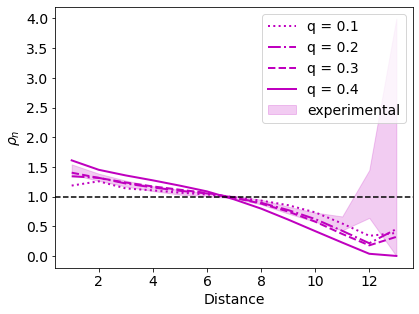

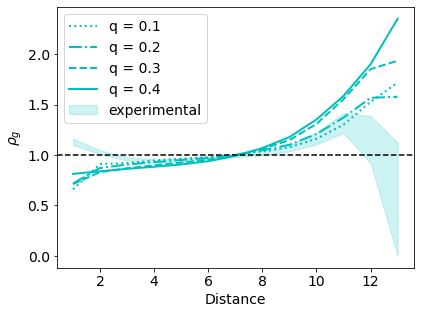

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds

def paircorrelation(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

ID = 20
#q = 0.2

N, G, Pop, Pos = loadExpData(ID)
GraphDist = graphdistance3D(Pos)
PN_min, PN_max, PG_min, PG_max = pc_bounds(Pop, GraphDist, 1000)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PN = paircorrelation(N, G, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
        
    plt.plot(ranges, PN, 'm', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')


plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PN_min, PN_max, color='m', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".png")

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PG = paircorrelation(G, N, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
 
    plt.plot(ranges, PG, 'c', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PG_min, PG_max, color='c', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".png")

Organoid 62 is 48h old
Organoid 62 consists of 1051 cells
Organoid 62 consists of 546 NANOG cells
Organoid 62 consists of 276 GATA6 cells
Organoid 62 has a NANOG:GATA6 ratio of 1.9782608695652173


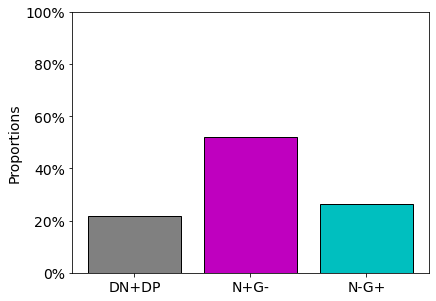

In [107]:
ID = 62
N, G, Pop, Pos = loadExpData(ID)

nofD = len(N[(Pop == 'N-G-') | (Pop == 'N+G+')])/len(N)*100
nofN = len(N[Pop == 'N+G-'])/len(N)*100
nofG = len(N[Pop == 'N-G+'])/len(N)*100

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.bar(['DN+DP', 'N+G-', 'N-G+'], [nofD, nofN, nofG], color=['gray', 'm', 'c'], edgecolor='k')
plt.ylim([0,100])
plt.ylabel('Proportions')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.savefig("Results/Publications/Pattern Formation/Proportions ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/Proportions ID = " + str(ID) + ".png")

Expected cell division time = 3.53156223514816
Expected number of Cells = 861.8099494976175
Organoid with 884 cells is ready!


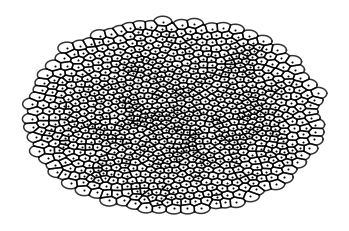

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

DATA = pd.DataFrame()

Prm = setParameters()
Prm.nofCells_end = 1000
Organoid = initializeOrganoid(Prm, Transcription=False)
print("Organoid with " + str(len(Organoid.Pos)) + " cells is ready!")

FVmesh = initializeFVmesh(Organoid.Pos, Radius = np.ones(len(Organoid.Pos))*np.mean(Organoid.Radius))
FVmesh.plot()

In [81]:
Prm.T = 240
Prm.nofSteps = 30000
t = np.linspace(0,Prm.T,Prm.nofSteps)
n = 100
indices = np.linspace(0,len(Organoid.Data)-1,n+1)

DATA = pd.DataFrame()
for j, i in enumerate(indices[1:]):
    index = int(i)
    Pos = Organoid.Data[index][1]
    Rad = Organoid.Data[index][2]
    FVmesh = initializeFVmesh(Pos, Radius = Rad)
    
    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = np.empty([2*FVmesh.nofCells, Prm.nofSteps+1])
    sol[:,0] = xInit
    for k in range(Prm.nofSteps):
        sol[:,k+1] = sol[:,k] + (t[1]-t[0])*rhs(t[k], sol[:,k])

    N = sol[:FVmesh.nofCells,-1]
    G = sol[FVmesh.nofCells:,-1]
    F = fate(N,G)
   
    print('ID =', j, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

    df = pd.DataFrame()
    df['ID'] = j*np.ones(len(F), dtype=int)
    df['x'] = Pos[:,0]
    df['y'] = Pos[:,1]
    df['fate'] = F
    df['NANOG'] = N
    df['GATA6'] = G
    DATA = DATA.append(df)
    

ID = 0 Total = 9 NANOG = 2 GATA6 = 7
ID = 1 Total = 9 NANOG = 2 GATA6 = 7
ID = 2 Total = 9 NANOG = 3 GATA6 = 6
ID = 3 Total = 9 NANOG = 3 GATA6 = 6
ID = 4 Total = 9 NANOG = 2 GATA6 = 7
ID = 5 Total = 10 NANOG = 3 GATA6 = 7
ID = 6 Total = 10 NANOG = 3 GATA6 = 7
ID = 7 Total = 10 NANOG = 3 GATA6 = 7
ID = 8 Total = 12 NANOG = 5 GATA6 = 7
ID = 9 Total = 12 NANOG = 5 GATA6 = 7
ID = 10 Total = 12 NANOG = 5 GATA6 = 7
ID = 11 Total = 12 NANOG = 5 GATA6 = 7
ID = 12 Total = 13 NANOG = 5 GATA6 = 8
ID = 13 Total = 15 NANOG = 6 GATA6 = 9
ID = 14 Total = 15 NANOG = 5 GATA6 = 10
ID = 15 Total = 17 NANOG = 5 GATA6 = 12
ID = 16 Total = 17 NANOG = 6 GATA6 = 11
ID = 17 Total = 18 NANOG = 7 GATA6 = 11
ID = 18 Total = 19 NANOG = 7 GATA6 = 12
ID = 19 Total = 19 NANOG = 6 GATA6 = 13
ID = 20 Total = 19 NANOG = 6 GATA6 = 13
ID = 21 Total = 20 NANOG = 8 GATA6 = 12
ID = 22 Total = 21 NANOG = 8 GATA6 = 13
ID = 23 Total = 21 NANOG = 8 GATA6 = 13
ID = 24 Total = 22 NANOG = 8 GATA6 = 14
ID = 25 Total = 24 NANOG = 8 

In [142]:
x = DATA['x'].to_numpy()
y = DATA['y'].to_numpy()

Pos = np.concatenate(([x], [y]), axis=0).T
print(Pos.shape, Pos)

(18431, 2) [[ 6.31760990e-02 -1.00939322e-02]
 [-9.58225391e-01  9.95696894e-01]
 [-8.01081417e-01 -9.97240295e-01]
 ...
 [-4.66802588e+00  2.49399260e+00]
 [-9.63274151e+00  1.63431946e+00]
 [-2.73452238e+00 -1.03006584e+01]]


In [136]:
a = np.array([1,2,3])
b = np.array([1,2,3])
np.concatenate(([a],[b]))

array([[1, 2, 3],
       [1, 2, 3]])

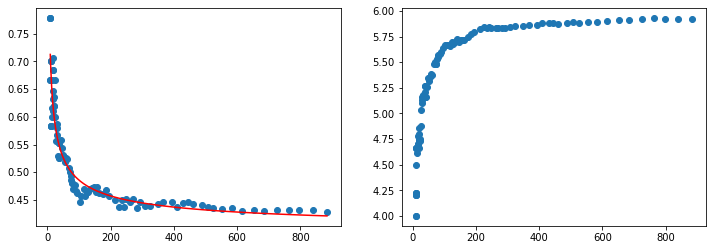

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from FVmesh import initializeFVmesh

DATA = pd.read_csv('ratio_size_comparison.csv')

IDs = np.unique(DATA['ID'])
size = np.empty(len(IDs))
nofN = np.empty(len(IDs))
nofG = np.empty(len(IDs))
ratio = np.empty(len(IDs))
nofNeigh = np.zeros(len(IDs))
for i, j in enumerate(IDs):
    org = DATA[DATA['ID'] == j]
    size[i] = len(org)
    nofN[i] = len(org[org['fate'] == 1])/len(org)
    nofG[i] = len(org[org['fate'] == 0])/len(org)
    ratio[i] = len(org[org['fate'] == 1])/len(org[org['fate'] == 0])
    
    x = org['x'].to_numpy()
    y = org['y'].to_numpy()

    Pos = np.concatenate(([x], [y]), axis=0).T
    FVmesh = initializeFVmesh(Pos, Radius = 0.8*np.ones(len(Pos)))
    for k in FVmesh.Neigh:
        nofNeigh[i] += len(k)/len(org)
    
    
def f(x, a, b):
    return a*x**(-1/2)+b

from scipy.optimize import curve_fit

plt.figure(figsize=(12,4))
plt.subplot(121)
popt, pcov = curve_fit(f, size, nofG)
plt.scatter(size, nofG)
plt.plot(size, f(size, *popt), 'r')

plt.subplot(122)
plt.scatter(size, nofNeigh)

[-0.97171063  0.61136   ] [-6.04164908  6.18684321]
[[ 1.       -0.970117]
 [-0.970117  1.      ]]
[[1.       0.970117]
 [0.970117 1.      ]]


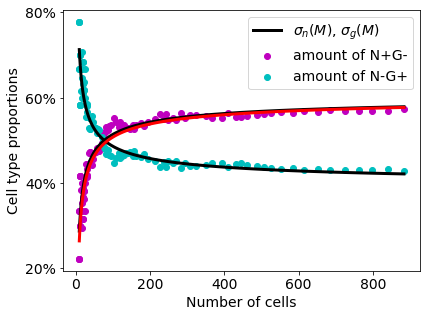

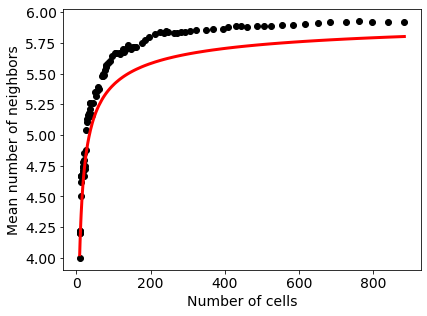

In [83]:
def f(x, a, b):
    return a*x**(-1/2)+b

def g(x, a, b):
    return a*x**(-1/2)+b

def h(x, a, b):
    return  a/g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b

def k(x, a, b):
    return  a*g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b

def l(x, p, a, b):
    from scipy.special import binom
    binom_a = 0
    for i in range(1,a+1):
        binom_a += binom(a,i)*p**i
    binom_b = 0
    for i in range(1,b+1):
        binom_b += binom(b,i)*p**i
        
    return p*binom_a - 2*np.pi**(1/2)/x**(1/2)*p*(binom_a - binom_b)
        
    


popt_f, pcov = curve_fit(f, size, nofN)
popt_g, pcov = curve_fit(g, size, nofNeigh)
print(popt_f, popt_g)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(size, nofN*100, color='m', label='amount of N+G-')
plt.scatter(size, nofG*100, color='c', label='amount of N-G+')
plt.plot(size, f(size, *popt_f)*100, 'k', lw=3, label='$\sigma_n(M)$, $\sigma_g(M)$')
plt.plot(size, 1*100-f(size, *popt_f)*100, 'k', lw=3)
plt.plot(size, l(size, 0.237, 6, 4)*100, 'r', lw=3)
plt.xlabel('Number of cells')
plt.ylabel('Cell type proportions')
ticks = [20,40,60,80]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.legend()

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(size[1:], nofNeigh[1:], color='k')
plt.plot(size, g(size, *[-2*np.pi**(1/2)*1.67, 6]), 'r', lw=3)
plt.xlabel('Number of cells')
plt.ylabel('Mean number of neighbors')

print(np.corrcoef(nofG, nofNeigh))
print(np.corrcoef(nofN, nofNeigh))

In [82]:
print(size[5:])

[ 10.  10.  10.  12.  12.  12.  12.  13.  15.  15.  17.  17.  18.  19.
  19.  19.  20.  21.  21.  22.  24.  25.  27.  29.  30.  31.  34.  38.
  38.  38.  38.  38.  43.  46.  49.  53.  56.  59.  61.  69.  72.  73.
  74.  77.  79.  81.  86.  90.  95. 103. 107. 115. 118. 125. 129. 134.
 140. 146. 153. 156. 162. 176. 184. 195. 213. 226. 236. 242. 248. 262.
 270. 282. 293. 307. 323. 350. 367. 394. 410. 430. 444. 461. 488. 507.
 525. 553. 584. 615. 652. 684. 726. 763. 797. 840. 884.]


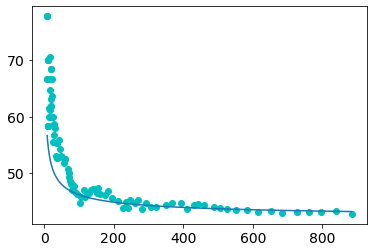

In [116]:
p = 2.5
func = 1/6*p - 2*np.pi**(1/2)/size**(1/2)*(1/6 - 1/4.6)*p
plt.plot(size, func*100)
plt.scatter(size, nofG*100, color='c', label='amount of N-G+')

5.983790523690773 0.6651170155686724 4.329268292682927 0.7166125947440958 802 82


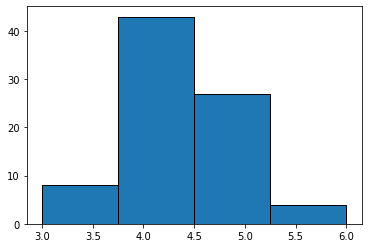

In [360]:
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist


A = []
B = []
tri = Delaunay(Pos)
dist = cdist(Pos, Pos)
boundary = set()
Rad = Organoid.Data[index][2]

for i,k in enumerate(FVmesh.Neigh):
    if (x[i]**2 + y[i]**2)**(1/2) > 12.3:
        num = 0
        for val in k:
            if dist[i, val] < Rad[i] + Rad[val]:
                num += 1
                
        B.append(num)
    else:
        num = 0
        for val in k:
            if dist[i, val] < Rad[i] + Rad[val]:
                num += 1
        A.append(num)

print(np.mean(A), np.std(A), np.mean(B), np.std(B), len(A), len(B))
plt.hist(B, 4, edgecolor='black');

In [317]:
A = []
for k in FVmesh.Neigh:
    A.append(len(k))
    
print(np.mean(A))

5.918552036199095


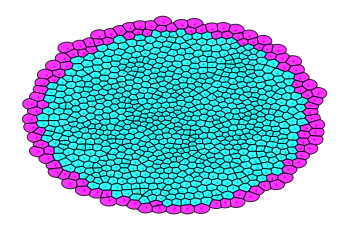

In [355]:
N = np.zeros(len(Pos))
N[(x**2 + y**2)**(1/2) > 12.0] = 1
FVmesh.plot(N)